In [1]:
import os, sys, time
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import mvpa2.suite as mvpa2
import itertools

from collections import Counter

import matplotlib.pylab as plt
%matplotlib inline

from scipy.spatial.distance import pdist,squareform

TR = 2.3

brands = np.array(['abercrombie-fitch','adobe','apple','axe','beats',
          'campina','dell','disney','durex','heineken','kelloggs',
          'microsoft','pampers','redbull'])

cat_names = ['party','work','sex','family']

sns.reset_orig()
plt.rc('font', family='Arial', size=16)
plt.rc('legend', fontsize='medium')
plt.rc('savefig', dpi=300)

In [2]:
def zscore(data):
    return (data-np.nanmean(data))/np.nanstd(data)
def mean_corr(data):
    return np.tanh(np.mean(np.arctanh(data)))

In [5]:
def draw_rdm_pub(rdm,output=None):
    brands = np.array(['abercrombie-fitch','adobe','apple',
                       'axe','beats',
              'campina','dell','disney','durex','heineken','kelloggs',
              'microsoft','pampers','redbull'])

    new_order = ['abercrombie-fitch','axe','durex',
                 'heineken','redbull',             
                 'beats','apple',
                 'adobe',
                 'dell','microsoft',
                 'campina','disney','kelloggs','pampers']

    brand_names = ['A&F','Axe','Durex',
                 'Heineken','Red Bull',             
                 'Beats','Apple',
                   'Adobe',
                 'Dell','Microsoft',
                 'Campina','Disney','Kellogg\'s','Pampers']

    brand_name_y = [b+'\n' for b in brand_names]
    brand_name_x = ['\n'+b for b in brand_names]
    
    minrdm = np.min(rdm)
    maxrdm = np.max(rdm)
    rdm_avg = (rdm - minrdm) / (maxrdm - minrdm)
    rdm_square = squareform(rdm_avg) 

    new_rdm = np.zeros(rdm_square.shape)

    for i in range(14):
        for j in range(i,14):
            ib = new_order[i].lower()
            jb = new_order[j].lower()
            new_rdm[i,j] = rdm_square[np.where(brands == ib)[0],np.where(brands == jb)[0]]
            new_rdm[j,i] = new_rdm[i,j]

    hfont = {'fontname':'Arial'}
    plt.rc('font', family='Arial',size=8)

    plt.figure(figsize=(2,2))
    fig = plt.gcf()
    ax = plt.gca()
    ax.axis('off')

    # Plot
    #axi = fig.add_axes([0.15, 0.1, 0.7, 0.7])
    axi = fig.add_axes([0.15, 0.1, 0.9, 0.9])
    im = axi.imshow(new_rdm, interpolation="nearest", 
                            aspect='equal', extent=(0, 14, 0, 14),vmin=0,vmax=1)
    axi.set_xticks(range(14))
    axi.set_yticks(range(14)[::-1])
    axi.set_xticklabels(brand_name_x,rotation=90)
    axi.set_yticklabels(brand_name_y)
    
    axi.yaxis.set_tick_params(size=0)
    axi.xaxis.set_tick_params(size=0)
    #axcb = fig.add_axes([0.9, 0.1, 0.02, 0.7])
    #cb = plt.colorbar(im, cax=axcb, format='%d',ticks=[0, 1])
    
    if output != None:
        plt.savefig(output,format='pdf',bbox_inches='tight')
    
    plt.show()        

In [21]:
def plot_tree_pub(data,sort=True,output=None):
    if sort==True:
        data.sort()
    
    plt.rc('font', family='Arial', size=8)    
    ax, fig = plt.subplots(figsize=(3.3,2))
    
    fig.spines['top'].set_visible(False)
    fig.spines['right'].set_visible(False)
    fig.spines['bottom'].set_visible(False)
    fig.spines['left'].set_visible(False)

    fig.xaxis.set_ticks_position('none') 
    fig.yaxis.set_ticks_position('none') 

    for i in range(len(data)):
        fig.plot([i+1,i+1],[0,data[i]],'k-',lw=0.5)
    fig.plot(range(1,len(data)+1),data,'ko',markersize=3)
    fig.set_xlim([0.5,len(data)+0.5])
    fig.set_xlabel('Subject',size=8)
    
    fig.set_yticks([-0.1,0,0.1,0.2,0.3])
    fig.set_ylim([-0.15,0.35])
    fig.plot([0.5,len(data)+0.5],[0,0],'k-',lw=0.5)

    if output != None:
        plt.savefig(output,format='pdf',bbox_inches='tight')
    
    plt.show()

In [6]:
cobrand_judgment = np.loadtxt('../survey/post/cobrand_judgment.csv',delimiter=',')
cobrand_score = np.sum(cobrand_judgment,axis=1)
cobrand_score = cobrand_score.reshape(((len(cobrand_score)/91),91))

cobrand_score[cobrand_score == -3] = np.nan
cobrand_rdm_avg = np.nanmean(cobrand_score,axis=0) / 3

In [7]:
method = 'normalized_common'
r = 'picture_thresh2'

file_path = '../output/'+method+'/'+r.replace("picture","brand")

subj_brand_ds = {}
allsubjs = np.array(range(4,42))

for subj in allsubjs:
    subj_brand_ds[subj] = mvpa2.Dataset.from_hdf5(file_path+'/S'+str(subj)+'.h5py')

In [8]:
TR_type = 't012'
tp = 6

subj_behave = []
subj_neural = []

rdm_dist = []

subjs = allsubjs[(allsubjs != 8)]

for subj in subjs:

    brand_ds = subj_brand_ds[subj]

    rdm_file =  '../mds/S'+str(subj)+'_mds.mat'
    behave_rdm = np.ravel(sp.io.loadmat(rdm_file)['estimate_dissimMat_ltv'])

    neural_rdm = []
    for b in range(14):
        neural_rdm.append(np.mean(np.array(brand_ds[(brand_ds.sa.brand == brands[b]) & \
                                 (brand_ds.sa.timepoint >= tp) & \
                                 (brand_ds.sa.timepoint < tp+TR)]\
                                .sa[TR_type+'_rsa']),axis=0))

    neural_rdm = pdist(np.array(neural_rdm),metric='correlation')

    #rdm_dist.append(sp.stats.pearsonr(neural_rdm,behave_rdm)[0])
    rdm_dist.append(sp.stats.spearmanr(neural_rdm,behave_rdm)[0])

    subj_behave.append(behave_rdm)
    subj_neural.append(neural_rdm)

behave_rdm_avg = np.mean(np.array(subj_behave),axis=0)
neural_rdm_avg = np.mean(np.array(subj_neural),axis=0)

#np.savetxt('brand_'+method+'_'+r+'_rdm.csv',np.vstack([behave_rdm_avg,neural_rdm_avg,cobrand_rdm_avg]).T,delimiter=',',fmt='%f',header='behave,neural,cobrand',comments='')

print mean_corr(rdm_dist), sp.stats.ttest_1samp(np.arctanh(rdm_dist),0), sp.stats.spearmanr(neural_rdm_avg,cobrand_rdm_avg)

0.100405473642 Ttest_1sampResult(statistic=5.9162125061778177, pvalue=8.9929291769251449e-07) SpearmanrResult(correlation=-0.3100493709189362, pvalue=0.0027818444496316972)


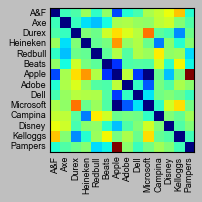

In [31]:
#draw_rdm(neural_rdm_avg,'neural_rdm.pdf')
draw_rdm_pub(neural_rdm_avg,'neural_rdm_pub.pdf')

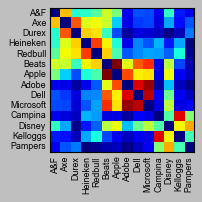

In [32]:
draw_rdm_pub(cobrand_rdm_avg,'cobrand_rdm_outofsample_pub.pdf')

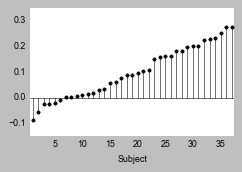

In [22]:
#plot_tree(rdm_dist,True,'rdm_dist.pdf')
plot_tree_pub(rdm_dist,True,'rdm_dist_pub.pdf')